<h1><center>Réseau de neuronnes projet</center>

 

# Importation des librairies 

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import os 
import sklearn 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Compatibilité des versions 

In [3]:
condition = (sklearn.__version__>="0.21.3" and tf.version.VERSION >= "2.1.0" and pd.__version__ >= "1.0.3" and np.__version__ >= "1.17.2" and matplotlib.__version__ >= "3.2.1")

if condition:
    print("Les versions des bibliothèques sont adéquates")
else:
    print("Veuillez mettre à jour les versions des bibliothèques")


Les versions des bibliothèques sont adéquates


# Exploration de la data

In [4]:
data_explore = pd.read_csv('mnist_all.csv', header=None,sep=',',encoding ='UTF-8')

In [5]:
data_explore.shape

(70000, 785)

In [7]:
print('Pas de valeur NULL dans la data.') if data_explore.isnull().values.any()==False else print('Valeur NULL existe')

Pas de valeur NULL dans la data.


# Lecture des données 

La lecture se fait à partir du disque local du fichier csv **"mnist_all.csv"** enregistré dans le dossier data.

In [10]:
def load_data(file, header=None):
    df = pd.read_csv(file, header=header,encoding ='UTF-8')
    df.rename(columns = {0:'classe'},inplace=True)
    return df


In [14]:
df_mnist = load_data("data/mnist_all.csv")


# Division des données

La division des données se fera en 2 étapes :

- étape 1 : Prendre un pourcentage (p_test) des données pour le test et un autre pour l'entraînement et la vlaidation

- étape 2 : De la base de données d'entraînement et de validation, définir une portion pour l'entraînement et une autres pour la validation

On charge les données enregistrées avec la fonction divide_data_stratified et on ramène leur échelle entre 0 et 1 sachant que la valeur maximale dans toute la dataframe est 255 (max niveau gris)   

In [15]:
#ici on divise les données d'une manière équilibrée 
#(chaqu'une des base train test val contient le meme nombre des données de chaque classe)
#on normalise les données eton les stocks 
def scale_divide_data_stratified(df,p_train=0.9,p_test=0.1,p_val=0.1):
    y = df["classe"]
    X = df.drop(columns=["classe"])
    X = X / 255.0
    # The stratify attribute is to have the same portion of classes in train, validation and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=p_test, random_state=42,stratify=y)
    X_train,X_val,y_train,y_val = train_test_split(X_train_val, y_train_val, test_size=p_val, 
                                                   random_state=42,stratify=y_train_val)
    
    filenames = ["data/X_train.csv","data/X_test.csv","data/X_val.csv","data/y_train.csv",
                 "data/y_test.csv","data/y_val.csv"]
    os.makedirs("data", exist_ok=True)
    data = [X_train,X_test,X_val,y_train,y_test,y_val]
    for i in range(len(data)):
        data[i].to_csv(filenames[i])
    
    return X_train,y_train,X_val,y_val,X_test,y_test
    
    

In [16]:
X_train,y_train,X_val,y_val,X_test,y_test = scale_divide_data_stratified(df_mnist)

# Creation de dataset adaptée à la biblio tensorflow

In [17]:
def prepare_dataset(X,y,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))
    dataset = dataset.shuffle(len(X)).batch(batch_size)
    return dataset



In [18]:
batch_size = 64
dataset_train = prepare_dataset(X_train,y_train,batch_size)
dataset_val = prepare_dataset(X_val,y_val,batch_size)
dataset_test = prepare_dataset(X_test,y_test,batch_size)

In [19]:
dataset_train

<BatchDataset shapes: ((None, 784), (None,)), types: (tf.float64, tf.int64)>

# Creation du modèle "perceptron multicouche"

In [20]:
#cette fonction permet de creer un modele selon les parametres à insérer
def create_model(input_size,num_layers,units,activation,optimizer):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_size))
    for i in range(num_layers):
        model.add(tf.keras.layers.Dense(units[i], activation=activation))
              
    model.add(tf.keras.layers.Dense(10, activation='softmax'))


    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# Sauvegarde du modèle en continue

In [22]:
#cette fonction permet de sauvgarder les résultats
def sauvegarde(path):
  pathc = path
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=pathc,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
  return model_checkpoint_callback

#  Exemple d'utilisation

In [23]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_test = create_model(784,3,[500,300,100],"relu",adam_optimizer)
h = model_test.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_val,
        callbacks=[model_checkpoint_callback]    
    )




Epoch 1/10
886/886 [==============================] - 15s 8ms/step - loss: 0.3746 - accuracy: 0.8903 - val_loss: 0.1286 - val_accuracy: 0.9622
Epoch 2/10
886/886 [==============================] - 8s 9ms/step - loss: 0.0858 - accuracy: 0.9730 - val_loss: 0.0946 - val_accuracy: 0.9716
Epoch 3/10
886/886 [==============================] - 9s 9ms/step - loss: 0.0535 - accuracy: 0.9821 - val_loss: 0.0913 - val_accuracy: 0.9732
Epoch 4/10
886/886 [==============================] - 8s 8ms/step - loss: 0.0377 - accuracy: 0.9882 - val_loss: 0.0979 - val_accuracy: 0.9722
Epoch 5/10
886/886 [==============================] - 8s 8ms/step - loss: 0.0298 - accuracy: 0.9901 - val_loss: 0.0936 - val_accuracy: 0.9748
Epoch 6/10
886/886 [==============================] - 8s 9ms/step - loss: 0.0281 - accuracy: 0.9916 - val_loss: 0.1160 - val_accuracy: 0.9737
Epoch 7/10
886/886 [==============================] - 8s 9ms/step - loss: 0.0240 - accuracy: 0.9923 - val_loss: 0.0941 - val_accuracy: 0.9773
Epoch

In [24]:
model_test.load_weights(checkpoint_filepath)
res = model_test.evaluate(dataset_test, verbose=2, use_multiprocessing=True, return_dict=True)
print("results on test",res)


110/110 - 0s - loss: 0.0672 - accuracy: 0.9829
results on test {'loss': 0.0672256276011467, 'accuracy': 0.9828571677207947}


# Expérimentation et hypertunning des paramètres

Dans cette partie on étudiera l'influence des différents hyperparamètres du model sur l'accuracy d'entraînement, de validation et de test.
Les paramètres qui seront testés sont (dans l'ordre précisé) : 

- nombre de couches cachées
- nombre de cellules par couche cachée
- type de fonction d’activation
- type de l'optimizer
- taille du batch


# Fonctions d'affichage des résultats

In [29]:
def afficher(data,var, title):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(title)
    ax1.plot(data[var], data["training_acc"])
    ax2.plot(data[var], data["val_acc"])
    ax3.plot(data[var], data["test_acc"])
    ax1.title.set_text('Training accuracy')
    ax2.title.set_text('validation accuracy')
    ax3.title.set_text('test accuracy')

In [30]:
def afficher_1(data,var , title):
  #plt.figure(figsize=(14, 7))
  Labels=data[var]
  y_pos=np.arange(len(Labels))
  plt.bar(y_pos,data["training_acc"],width=0.2, color = '#2B6A99' , label='Training accuracy')
  plt.bar(y_pos+0.2,data["val_acc"], width=0.2,color = '#6488AE',label = 'validation accuracy')
  plt.bar(y_pos+0.4,data["test_acc"], width=0.2,color = '#C0CBD8',label = 'test accuracy')
  plt.xticks(y_pos+0.2, Labels)
  plt.legend(('Training accuracy','validation accuracy', 'test accuracy'))
  plt.ylabel('accuracy')
  plt.xlabel('optimizer')
  plt.title(title)

# Nombre de couches cachées

In [36]:
# we fix all other params and only change the num of hidden layers
# we also take the best accuracy for th trained model (without specifying the epoch)

num_hidden_layers = [1,2,3,4,5]
units = [[500],[500,400],[500,400,300],[500,400,300,200],[500,400,300,200,100]]
train_accuracy = []
val_accuracy = []
test_accuracy = []
for i in range(5):
    checkpoint_filepath = 'tmp/checkpoint_layers_'
    checkpoint_filepath += str(i)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model = create_model(784,num_hidden_layers[i],units[i],"relu",adam_optimizer)
    h = model.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_val,
        verbose=0,
        callbacks=[model_checkpoint_callback] 
    )
    train_accuracy.append(max(h.history["accuracy"]))
    val_accuracy.append(max(h.history["val_accuracy"]))
    model.load_weights(checkpoint_filepath)
    res_test = model.evaluate(dataset_test, verbose=0, use_multiprocessing=True, return_dict=True)
    test_accuracy.append(res_test["accuracy"])

df_num_layers = pd.DataFrame({"num_layers":num_hidden_layers,
                             "training_acc": train_accuracy,
                             "val_acc": val_accuracy,
                             "test_acc":test_accuracy})

print(df_num_layers)
    
    

   num_layers  training_acc   val_acc  test_acc
0           1      0.997760  0.979365  0.982571
1           2      0.996420  0.977619  0.979857
2           3      0.995115  0.979206  0.979000
3           4      0.995097  0.979841  0.980429
4           5      0.994621  0.979683  0.979571


la raison pour laquelle l'accuracy décroit considérablement en utilisant 4 ou 5 layers est que le nombre des weights à calibrer est très grand qu'il faut plus d'epoch pour entraîner le réseau. 

On remarque que l'utilisation d'une **seule hidden layer** est suffisant, elle donne des résultats supérieurs sur le train, validation et test

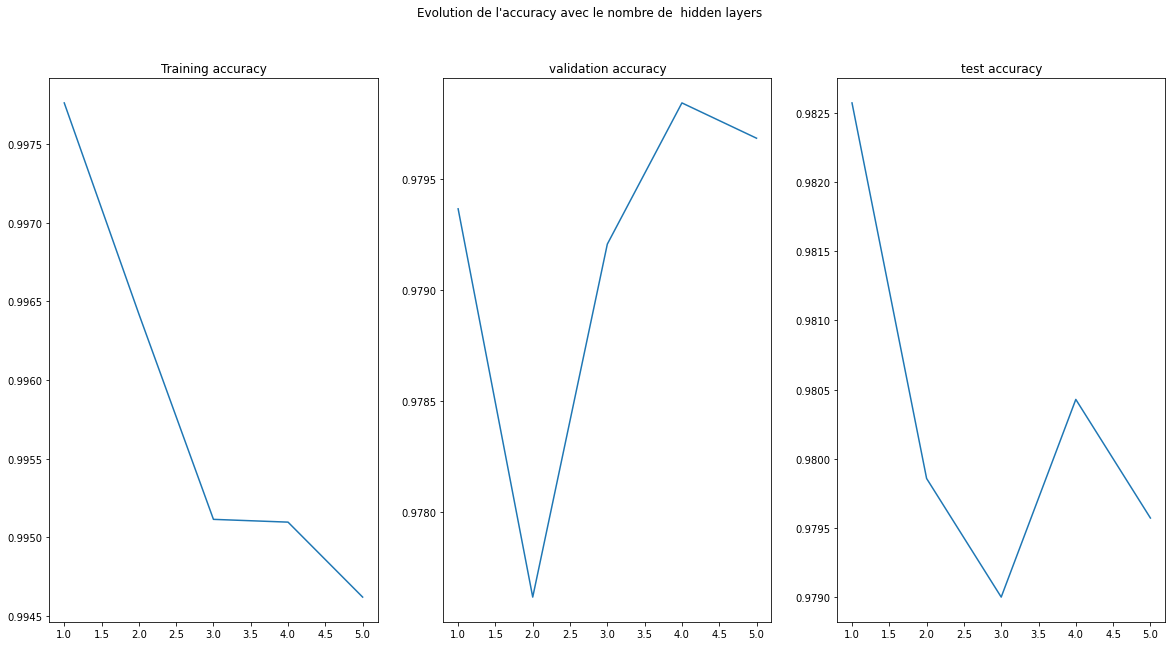

In [37]:
afficher(df_num_layers,"num_layers","Evolution de l'accuracy avec le nombre de  hidden layers")

# Nombre de cellules 

In [38]:
units = [[i] for i in range(780,50,-100)]
train_accuracy = []
val_accuracy = []
test_accuracy = []
for i in range(len(units)):
    checkpoint_filepath = 'tmp/checkpoint_units_'
    checkpoint_filepath += str(units[i][0])
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model = create_model(784,1,units[i],"relu",adam_optimizer)
    h = model.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_val,
        verbose=0,
        callbacks=[model_checkpoint_callback] 
    )
    train_accuracy.append(max(h.history["accuracy"]))
    val_accuracy.append(max(h.history["val_accuracy"]))
    model.load_weights(checkpoint_filepath)
    res_test = model.evaluate(dataset_test, verbose=0, use_multiprocessing=True, return_dict=True)
    test_accuracy.append(res_test["accuracy"])

df_num_units = pd.DataFrame({"num_units":[x[0] for x in units],
                             "training_acc": train_accuracy,
                             "val_acc": val_accuracy,
                             "test_acc":test_accuracy})

print(df_num_units)


   num_units  training_acc   val_acc  test_acc
0        780      0.998272  0.979841  0.979286
1        680      0.998078  0.980952  0.981286
2        580      0.998007  0.979524  0.980286
3        480      0.998254  0.979365  0.981857
4        380      0.998571  0.979841  0.982857
5        280      0.997831  0.978413  0.979571
6        180      0.997637  0.979048  0.978857
7         80      0.992451  0.976825  0.974857


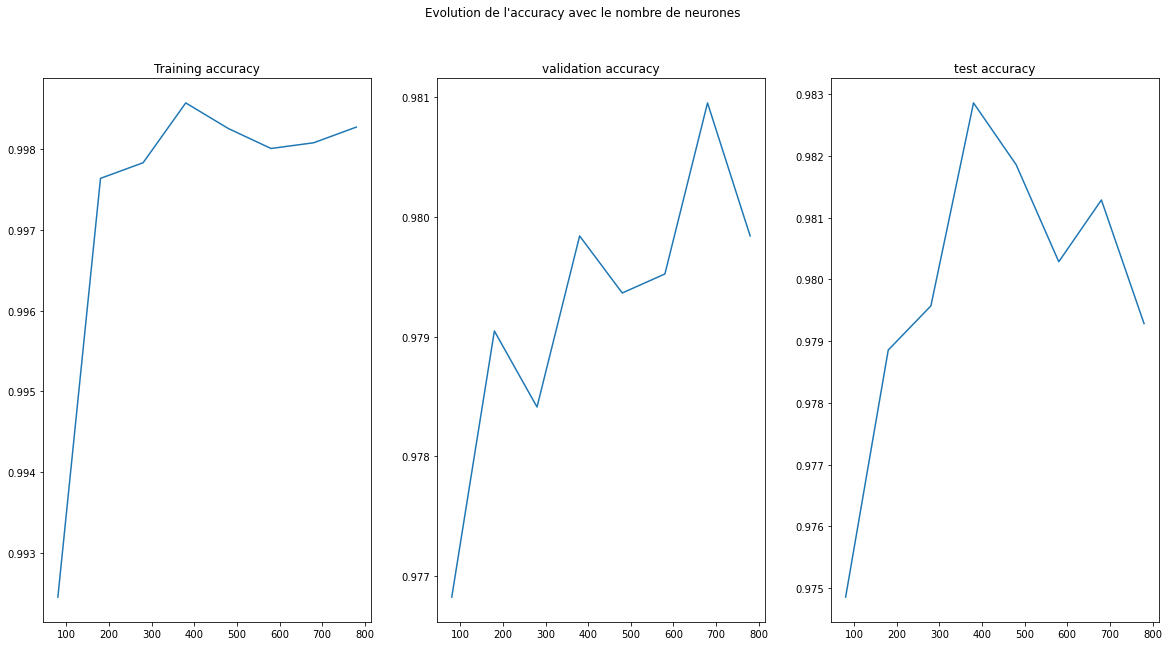

In [41]:
afficher(df_num_units,"num_units","Evolution de l'accuracy avec le nombre de neurones")

On prend le nombre des units égal à **380** car c'est lui qui donne la meilleur valeur de l'accuracy de test, le modèle commence à "overfitter" les données d'entrainement après cette valeur.

# Type de la fonction d'activation

In [42]:
activation = ["relu","sigmoid","tanh"]
train_accuracy = []
val_accuracy = []
test_accuracy = []
for x in activation:
    checkpoint_filepath = 'tmp/checkpoint_activation_'
    checkpoint_filepath += x
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model = create_model(784,1,[380],x,adam_optimizer)
    h = model.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_val,
        verbose=0,
        callbacks=[model_checkpoint_callback] 
    )
    train_accuracy.append(max(h.history["accuracy"]))
    val_accuracy.append(max(h.history["val_accuracy"]))
    model.load_weights(checkpoint_filepath)
    res_test = model.evaluate(dataset_test, verbose=0, use_multiprocessing=True, return_dict=True)
    test_accuracy.append(res_test["accuracy"])

df_activation = pd.DataFrame({"activation": activation,
                             "training_acc": train_accuracy,
                             "val_acc": val_accuracy,
                             "test_acc":test_accuracy})

print(df_activation)


  activation  training_acc   val_acc  test_acc
0       relu      0.998924  0.980317  0.983000
1    sigmoid      0.996684  0.979365  0.981000
2       tanh      0.998025  0.979206  0.980143


La fonction d'activation **ReLU** est la meilleur dans notre cas pour les hidden layers

#  Type de l'optimizer

In [46]:
optimizers = ['adam', 'adamax', 'rmsprop','sgd']

train_accuracy = []
val_accuracy = []
test_accuracy = []
for x in optimizers:
    checkpoint_filepath = 'tmp/checkpoint_optimizer_'
    checkpoint_filepath += str(x)
    
    model = create_model(784,1,[380],"relu",x)
    h = model.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_val,
        verbose=0,
        callbacks=[sauvegarde(checkpoint_filepath)] 
    )
    train_accuracy.append(max(h.history["accuracy"]))
    val_accuracy.append(max(h.history["val_accuracy"]))
    model.load_weights(checkpoint_filepath)
    res_test = model.evaluate(dataset_test, verbose=0, use_multiprocessing=True, return_dict=True)
    test_accuracy.append(res_test["accuracy"])

df_optimizers = pd.DataFrame({"optimizers": optimizers,
                             "training_acc": train_accuracy,
                             "val_acc": val_accuracy,
                             "test_acc":test_accuracy})

print(df_optimizers)

  optimizers  training_acc   val_acc  test_acc
0       adam      0.994656  0.978413  0.978143
1     adamax      0.999206  0.980476  0.980857
2    rmsprop      0.994515  0.980952  0.980143
3        sgd      0.956773  0.951587  0.953000


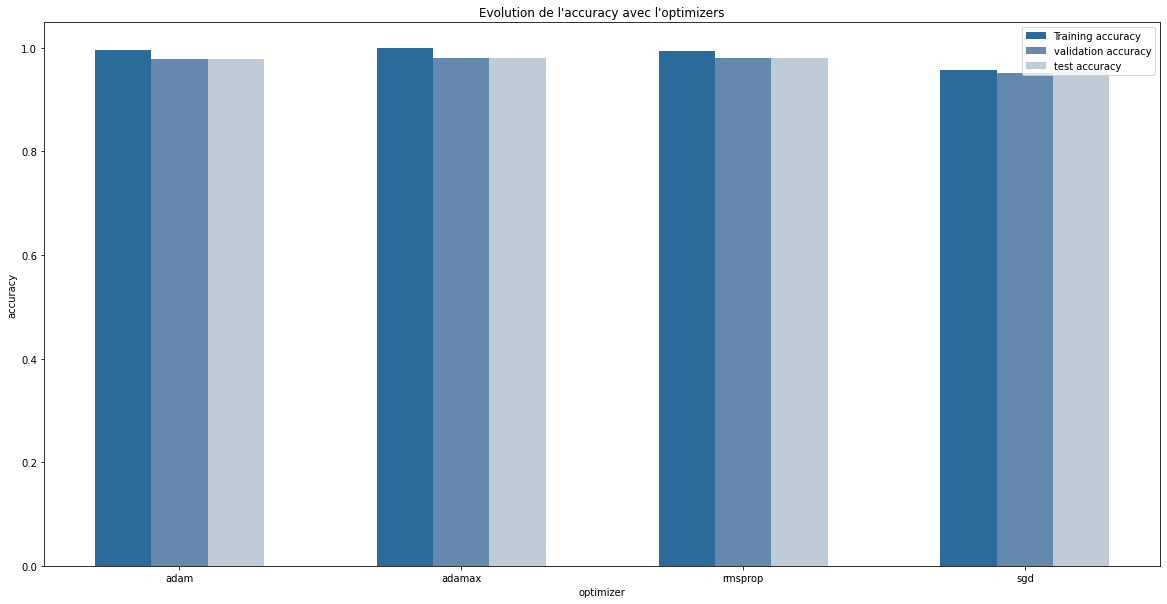

In [47]:
afficher_1(df_optimizers,"optimizers","Evolution de l'accuracy avec l'optimizers")

On utilisera **adamax** optimizer avec différent learning rate pour tester la convergence du gradient et choisir le meilleur learning rate

# Le choix du learning rate

In [49]:
learning_rates = [0.001,0.01,0.1,1]

train_accuracy = []
val_accuracy = []
test_accuracy = []
for x in learning_rates:
    checkpoint_filepath = 'tmp/checkpoint_optimizer_'
    checkpoint_filepath += str(x)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=x)
    model = create_model(784,1,[580],"relu",optimizer)
    h = model.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_val,
        verbose=0,
        callbacks=[model_checkpoint_callback] 
    )
    train_accuracy.append(max(h.history["accuracy"]))
    val_accuracy.append(max(h.history["val_accuracy"]))
    model.load_weights(checkpoint_filepath)
    res_test = model.evaluate(dataset_test, verbose=0, use_multiprocessing=True, return_dict=True)
    test_accuracy.append(res_test["accuracy"])

df_learning_rate = pd.DataFrame({"learning_rate": learning_rates,
                             "training_acc": train_accuracy,
                             "val_acc": val_accuracy,
                             "test_acc":test_accuracy})

print(df_learning_rate)


   learning_rate  training_acc   val_acc  test_acc
0          0.001      0.992011  0.976190  0.979000
1          0.010      0.999224  0.981111  0.982143
2          0.100      0.980265  0.966190  0.965714
3          1.000      0.804868  0.786667  0.792571


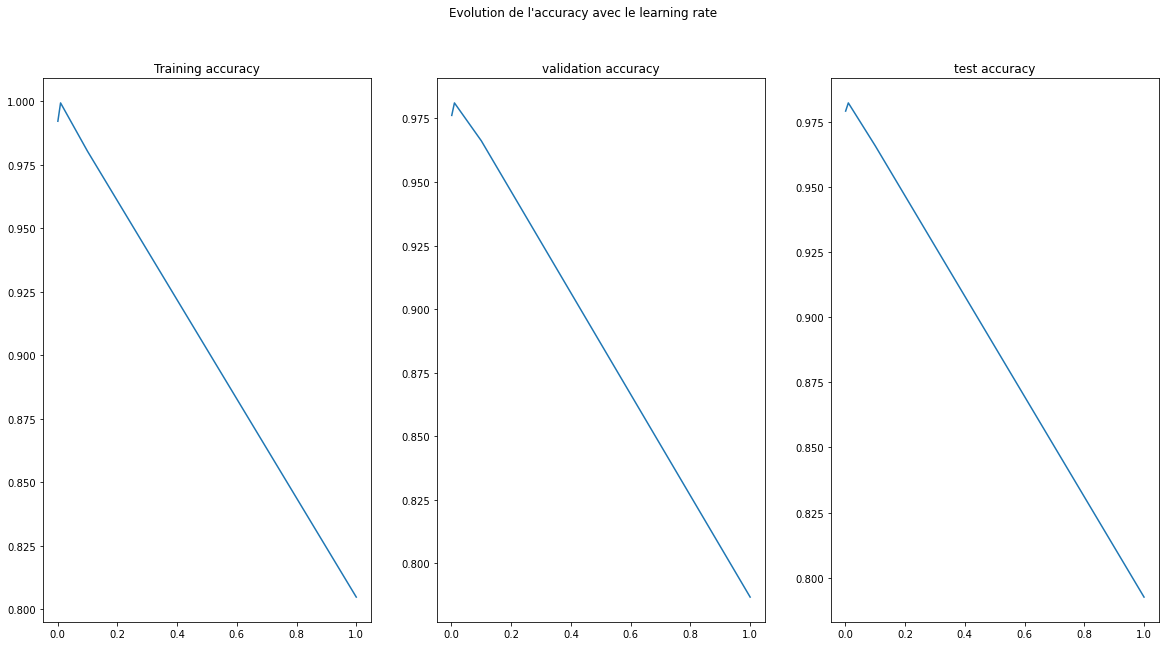

In [50]:
afficher(df_learning_rate,"learning_rate","Evolution de l'accuracy avec le learning rate")


On choisit le "learning rate" :  **0.010**

# Taille du batch

In [51]:
batch_sizes = [16,32,64,128,256]
train_accuracy = []
val_accuracy = []
test_accuracy = []
for x in batch_sizes:
    checkpoint_filepath = 'tmp/checkpoint_batch_'
    checkpoint_filepath += str(x)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    model = create_model(784,1,[380],"relu",tf.keras.optimizers.Adamax(learning_rate=0.010))
    dataset_train = prepare_dataset(X_train,y_train,x)
    dataset_val = prepare_dataset(X_val,y_val,x)
    dataset_test = prepare_dataset(X_test,y_test,x)
    h = model.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_val,
        verbose=0,
        callbacks=[model_checkpoint_callback] 
    )
    train_accuracy.append(max(h.history["accuracy"]))
    val_accuracy.append(max(h.history["val_accuracy"]))
    model.load_weights(checkpoint_filepath)
    res_test = model.evaluate(dataset_test, verbose=0, use_multiprocessing=True, return_dict=True)
    test_accuracy.append(res_test["accuracy"])

df_batch = pd.DataFrame({"batch_size": batch_sizes,
                             "training_acc": train_accuracy,
                             "val_acc": val_accuracy,
                             "test_acc":test_accuracy})

print(df_batch)


   batch_size  training_acc   val_acc  test_acc
0          16      0.998642  0.983175  0.981857
1          32      0.999030  0.981111  0.983286
2          64      0.998977  0.980635  0.981857
3         128      0.998095  0.980635  0.981286
4         256      0.998060  0.979048  0.981000


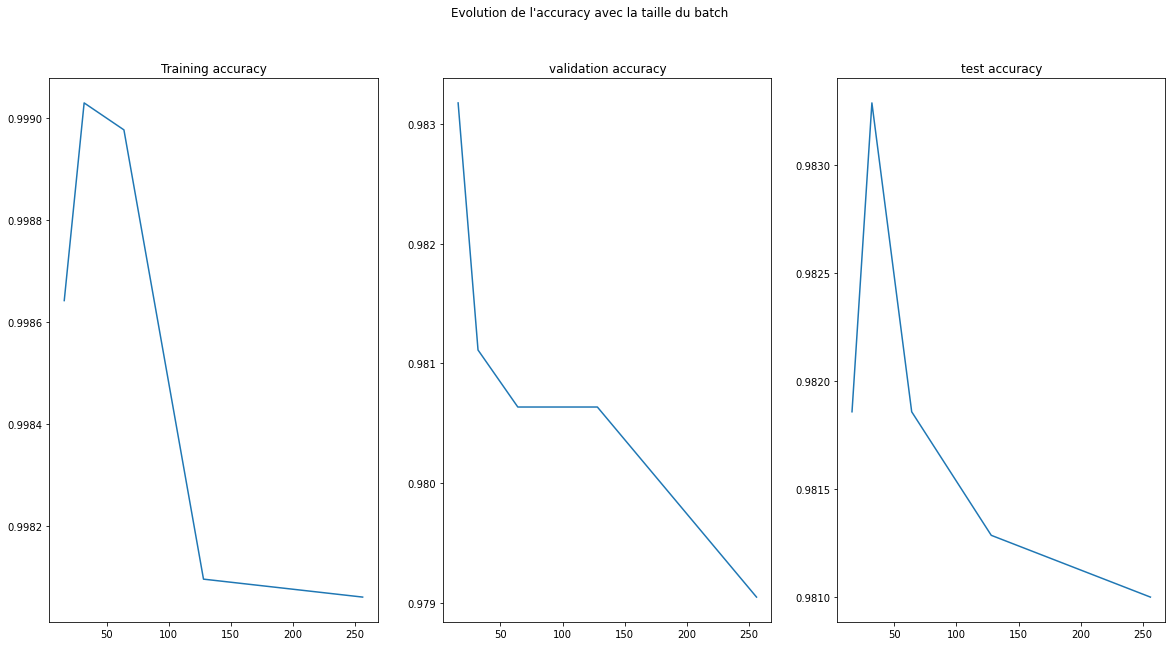

In [52]:
afficher(df_batch,"batch_size","Evolution de l'accuracy avec la taille du batch")

On choisit un batch size égal à **32**

# Modèle final 

Le modèle final optimal issu de cette partie d'expérimentation a les caractéristiques suivantes :

- Nombre de "hidden layers" : **1**

- Nombre de cellule dans la couches cachée : **380**

- Type de la fonction d'activation des couches cachées : **ReLu**

- L'optimizer : **Adamax**

- Learning rate de l'ADAMAX optimizer : **0.010**

- taille du batch : **32**

### Performances de ce modèle (train / validation et test accuracy)

In [53]:
checkpoint_filepath = 'tmp/checkpoint_final_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
model = create_model(784,1,[380],"relu",tf.keras.optimizers.Adamax(learning_rate=0.010))
dataset_train = prepare_dataset(X_train,y_train,32)
dataset_val = prepare_dataset(X_val,y_val,32)
dataset_test = prepare_dataset(X_test,y_test,32)
h = model.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_val,
        verbose=0,
        callbacks=[model_checkpoint_callback] 
    )

model.load_weights(checkpoint_filepath)
res_test = model.evaluate(dataset_test, verbose=0, use_multiprocessing=True, return_dict=True)
res_train = model.evaluate(dataset_train, verbose=0, use_multiprocessing=True, return_dict=True)
res_val = model.evaluate(dataset_val, verbose=0, use_multiprocessing=True, return_dict=True)

print("Les résultat sur la data d'entrainement sont : ",res_train)
print("Les résultat sur la data de validation sont : ",res_val)
print("Les résultat sur la data de test sont : ",res_test)

Les résultat sur la data d'entrainement sont :  {'loss': 0.00410290714353323, 'accuracy': 0.9991710782051086}
Les résultat sur la data de validation sont :  {'loss': 0.08019623905420303, 'accuracy': 0.9811111092567444}
Les résultat sur la data de test sont :  {'loss': 0.06177549436688423, 'accuracy': 0.9825714230537415}


# FIN